In [1]:
import os
import json
import math
import random
import pickle
import warnings
import numpy as np
from tqdm import tqdm
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import torch
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from resnet_wider import resnet50x1, resnet50x2, resnet50x4

/hdd2/nick/anaconda3/envs/subspaces/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tree_structure = "mintree"
per_class = 50

In [3]:
T = nx.Graph()

with open('../imagenet_' + tree_structure + '.txt', 'r') as f:
    for line in f.readlines():
        nodes = line.split()
        for node in nodes:
            if node not in T:
                T.add_node(node)
        T.add_edge(*nodes)
        
leaves = [x for x in T.nodes() if T.degree(x) == 1]
full_labels_loc = np.array(leaves)
length = dict(nx.all_pairs_shortest_path_length(T))

In [4]:
squared_distance_matrix = np.zeros((len(full_labels_loc), len(full_labels_loc)))

for i, each_class_loc_i in enumerate(full_labels_loc):
    for j, each_class_loc_j in enumerate(full_labels_loc):
        distance = length[each_class_loc_i][each_class_loc_j]
        squared_distance_matrix[i][j] = distance ** 2

In [5]:
f = open('../dir_label_name.json')
map_collection = json.load(f)
f.close()

In [6]:
train_X = np.load("../saved/train_X_1000_classes.npy")
train_y = np.load("../saved/train_y_1000_classes.npy")
test_X = np.load("../saved/test_X_1000_classes.npy")
test_y = np.load("../saved/test_y_1000_classes.npy")

In [7]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((50000, 2048), (50000,), (50000, 2048), (50000,))

In [8]:
loaded_model = pickle.load(open("../saved/simclr1x_lg_1000_classes_model.sav", 'rb'))

/hdd2/nick/anaconda3/envs/subspaces/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/hdd2/nick/anaconda3/envs/subspaces/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/hdd2/nick/anaconda3/envs/subspaces/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 1.1.1 when using version 1.2.0. 

In [9]:
# pred_prob = loaded_model.predict_proba(test_X)
# pred_prob.shape
# np.save("./saved/test_pred_prob_1000_classes.npy", pred_prob)

In [10]:
test_pred_prob = np.load("../saved/test_pred_prob_1000_classes.npy")

In [11]:
test_pred_prob.shape

(50000, 1000)

In [12]:
classes_ = [i for i in range(50, 1000, 100)]
classes_.insert(0, 10)
classes_.insert(2, 100)
classes_.insert(7, 500)
classes_.append(1000)

In [13]:
classes_

[10, 50, 100, 150, 250, 350, 450, 500, 550, 650, 750, 850, 950, 1000]

## Uniform Sampler

In [14]:
np.random.seed(123)

uniform_baseline_collection = []
uniform_proposed_method_collection = []

for num_of_sampled_classes in classes_:
    
    print(num_of_sampled_classes)
    sampled_classes = np.random.choice(1000, num_of_sampled_classes, replace=False)
    sampled_classes = np.sort(sampled_classes)  
    # print(sampled_classes)
    
    """
    pred_prob = []
    for c in tqdm(sampled_classes, total=len(sampled_classes)):
        prob = loaded_model.estimators_[c].predict_proba(test_X)[:, 1].T
        pred_prob.append(prob)
    pred_prob = np.array(pred_prob)
    """
    
    pred_prob_small = test_pred_prob.T[sampled_classes].T
    # print(pred_prob_small.shape)
       
    sorted_prediction = np.flip(np.argsort(pred_prob_small), axis=1)
    top10_prediction = sampled_classes[sorted_prediction[:, :10]]
    top5_prediction = sampled_classes[sorted_prediction[:, :5]]
    top1_prediction = sampled_classes[np.argmax(pred_prob_small, axis=1)]
    
    ## Squared Distance ##
    total_squared_distance = 0
    for pred, gt in zip(top1_prediction, test_y):
        total_squared_distance += squared_distance_matrix[pred][gt]
    avg_squared_distance = total_squared_distance / len(test_y)
    
    ## Top-1 Acc ##
    top1_acc = accuracy_score(top1_prediction, test_y)
    
    ## Top-5 Acc ##
    top5_correct = 0
    for pred_array, gt in zip(top5_prediction, test_y):
        if gt in pred_array: top5_correct += 1
    top5_acc = top5_correct / len(test_y)
    
    ## Top-10 Acc ##
    top10_correct = 0
    for pred_array, gt in zip(top10_prediction, test_y):
        if gt in pred_array: top10_correct += 1
    top10_acc = top10_correct / len(test_y)
    
    print("SimCLR + LG, AVG Squared Distance: ", avg_squared_distance)
    print("SimCLR + LG, Top 1 Accuracy: ", top1_acc)
    print("SimCLR + LG, Top 5 Accuracy: ", top5_acc)
    print("SimCLR + LG, Top 10 Accuracy: ", top10_acc)
    
    # ======================================================================== # 
    
    sorted_prediction_w_label_model = np.argsort(np.dot(pred_prob_small, squared_distance_matrix[sampled_classes]))
    top10_prediction_w_label_model = sorted_prediction_w_label_model[:, :10]
    top5_prediction_w_label_model = sorted_prediction_w_label_model[:, :5]
    top1_prediction_w_label_model = np.argmin(np.dot(pred_prob_small, squared_distance_matrix[sampled_classes]), axis=1)
    
    ## Squared Distance ##
    total_squared_distance_w_label_model = 0
    for pred, gt in zip(top1_prediction_w_label_model, test_y):
        total_squared_distance_w_label_model += squared_distance_matrix[pred][gt]
    avg_squared_distance_w_label_model = total_squared_distance_w_label_model / len(test_y)
        
    ## Top-1 Acc ##
    top1_acc_w_label_model = accuracy_score(top1_prediction_w_label_model, test_y)
    
    ## Top-5 Acc ##
    top5_correct_w_label_model = 0
    for pred_array, gt in zip(top5_prediction_w_label_model, test_y):
        if gt in pred_array: top5_correct_w_label_model += 1
    top5_acc_w_label_model = top5_correct_w_label_model / len(test_y)
    
    ## Top-10 Acc ##
    top10_correct_w_label_model = 0
    for pred_array, gt in zip(top10_prediction_w_label_model, test_y):
        if gt in pred_array: top10_correct_w_label_model += 1
    top10_acc_w_label_model = top10_correct_w_label_model / len(test_y)
    
    print("SimCLR + LG + Label Model, AVG Squared Distance: ", avg_squared_distance_w_label_model)
    print("SimCLR + LG + Label Model, Top 1 Accuracy: ", top1_acc_w_label_model)
    print("SimCLR + LG + Label Model, Top 5 Accuracy: ", top5_acc_w_label_model)
    print("SimCLR + LG + Label Model, Top 10 Accuracy: ", top10_acc_w_label_model)
    
    # ======================================================================== # 
    uniform_baseline_collection.append([avg_squared_distance, top1_acc, top5_acc, top10_acc])
    uniform_proposed_method_collection.append([avg_squared_distance_w_label_model, top1_acc_w_label_model, top5_acc_w_label_model, top10_acc_w_label_model])

10
SimCLR + LG, AVG Squared Distance:  218.50968
SimCLR + LG, Top 1 Accuracy:  0.00956
SimCLR + LG, Top 5 Accuracy:  0.00992
SimCLR + LG, Top 10 Accuracy:  0.01
SimCLR + LG + Label Model, AVG Squared Distance:  161.68292
SimCLR + LG + Label Model, Top 1 Accuracy:  0.00982
SimCLR + LG + Label Model, Top 5 Accuracy:  0.01532
SimCLR + LG + Label Model, Top 10 Accuracy:  0.02364
50
SimCLR + LG, AVG Squared Distance:  185.3226
SimCLR + LG, Top 1 Accuracy:  0.03934
SimCLR + LG, Top 5 Accuracy:  0.04734
SimCLR + LG, Top 10 Accuracy:  0.0488
SimCLR + LG + Label Model, AVG Squared Distance:  134.65982
SimCLR + LG + Label Model, Top 1 Accuracy:  0.0344
SimCLR + LG + Label Model, Top 5 Accuracy:  0.04826
SimCLR + LG + Label Model, Top 10 Accuracy:  0.05588
100
SimCLR + LG, AVG Squared Distance:  182.61742
SimCLR + LG, Top 1 Accuracy:  0.07668
SimCLR + LG, Top 5 Accuracy:  0.09244
SimCLR + LG, Top 10 Accuracy:  0.09582
SimCLR + LG + Label Model, AVG Squared Distance:  128.31066
SimCLR + LG + Label

In [15]:
uniform_baseline_collection = np.array(uniform_baseline_collection)
uniform_proposed_method_collection = np.array(uniform_proposed_method_collection)

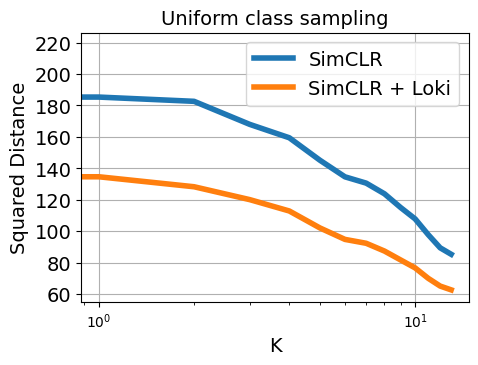

In [18]:
plt.figure(figsize=(5, 3.5))
plt.plot(uniform_baseline_collection[:, 0], label="SimCLR", linewidth=4)
plt.plot(uniform_proposed_method_collection[:, 0], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Squared Distance", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([60, 80, 100, 120, 140, 160, 180, 200, 220], [60, 80, 100, 120, 140, 160, 180, 200, 220], fontsize=14)
#plt.xticks([i for i in range(len(baseline_collection))], classes_, fontsize=14, rotation=45)
plt.xscale("log")
plt.title("Uniform class sampling", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

NameError: name 'baseline_collection' is not defined

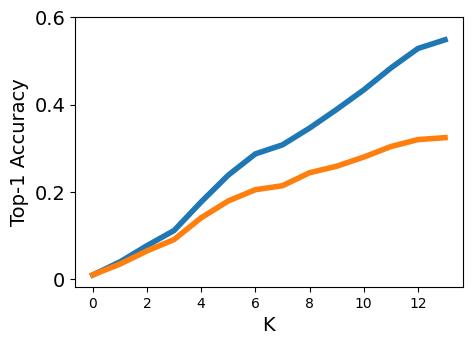

In [26]:
plt.figure(figsize=(5, 3.5))
plt.plot(uniform_baseline_collection[:, 1], label="SimCLR", linewidth=4)
plt.plot(uniform_proposed_method_collection[:, 1], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Top-1 Accuracy", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6], [0, 0.2, 0.4, 0.6], fontsize=14)
plt.xticks([i for i in range(len(baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Uniform distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

NameError: name 'baseline_collection' is not defined

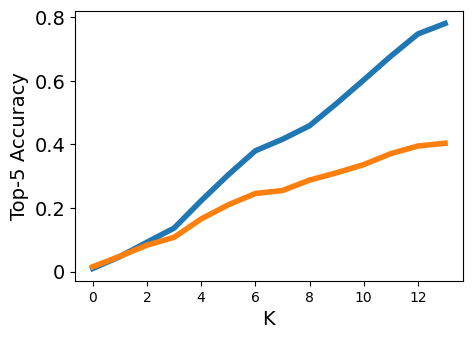

In [27]:
plt.figure(figsize=(5, 3.5))
plt.plot(uniform_baseline_collection[:, 2], label="SimCLR", linewidth=4)
plt.plot(uniform_proposed_method_collection[:, 2], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Top-5 Accuracy", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], [0, 0.2, 0.4, 0.6, 0.8], fontsize=14)
plt.xticks([i for i in range(len(baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Uniform distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

NameError: name 'baseline_collection' is not defined

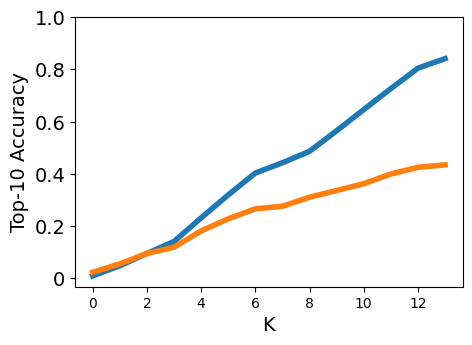

In [28]:
plt.figure(figsize=(5, 3.5))
plt.plot(uniform_baseline_collection[:, 3], label="SimCLR", linewidth=4)
plt.plot(uniform_proposed_method_collection[:, 3], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Top-10 Accuracy", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xticks([i for i in range(len(baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Uniform distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

## Exp Sampler

In [29]:
np.random.seed(123)

num_of_around_center = 10
exponential_baseline_collection = []
exponential_proposed_method_collection = []

for num_of_sampled_classes in classes_:
    print(num_of_sampled_classes)
    
    print("exponential sampler")
    center_node_index = np.argmin(np.sum(squared_distance_matrix, axis=1))

    possibility = []
    variance = 0.5
    for node_index in range(len(full_labels_loc)):
        dist = squared_distance_matrix[node_index][center_node_index]
        possibility.append(math.exp(-1 * variance * dist))
    possibility = np.array(possibility) / sum(possibility)

    sampled_classes = np.random.choice(len(full_labels_loc), num_of_sampled_classes, replace=False, p=possibility)
    sampled_classes = np.sort(sampled_classes)
    # print(sampled_classes)
    
    """
    distance_dict = {}
    for i in range(len(full_labels_loc)):
        for j in range(i + 1, len(full_labels_loc)):
            distance_dict[(i, j)] = squared_distance_matrix[i][j]
    sorted_distance_dict = dict(sorted(distance_dict.items(), key=lambda item: -item[1]))

    for key in sorted_distance_dict:
        if key[0] not in sampled_classes:
            if len(sampled_classes) + 1 <= num_of_sampled_classes:
                sampled_classes = np.append(sampled_classes, key[0])
            else:
                break
        if key[1] not in sampled_classes:
            if len(sampled_classes) + 1 <= num_of_sampled_classes:
                sampled_classes = np.append(sampled_classes, key[1])
            else:
                break
    sampled_classes = np.sort(sampled_classes)
    # print(sampled_classes)
    
    pred_prob = []
    for c in tqdm(sampled_classes, total=len(sampled_classes)):
        prob = loaded_model.estimators_[c].predict_proba(test_X)[:, 1].T
        pred_prob.append(prob)
    pred_prob = np.array(pred_prob)
    """
    
    pred_prob_small = test_pred_prob.T[sampled_classes].T
    print(pred_prob_small.shape)
    
    sorted_prediction = np.flip(np.argsort(pred_prob_small), axis=1)
    top10_prediction = sampled_classes[sorted_prediction[:, :10]]
    top5_prediction = sampled_classes[sorted_prediction[:, :5]]
    top1_prediction = sampled_classes[np.argmax(pred_prob_small, axis=1)]
    
    ## Squared Distance ##
    total_squared_distance = 0
    for pred, gt in zip(top1_prediction, test_y):
        total_squared_distance += squared_distance_matrix[pred][gt]
    avg_squared_distance = total_squared_distance / len(test_y)
    
    ## Top-1 Acc ##
    top1_acc = accuracy_score(top1_prediction, test_y)
    
    ## Top-5 Acc ##
    top5_correct = 0
    for pred_array, gt in zip(top5_prediction, test_y):
        if gt in pred_array: top5_correct += 1
    top5_acc = top5_correct / len(test_y)
    
    ## Top-10 Acc ##
    top10_correct = 0
    for pred_array, gt in zip(top10_prediction, test_y):
        if gt in pred_array: top10_correct += 1
    top10_acc = top10_correct / len(test_y)
    
    print("SimCLR + LG, AVG Squared Distance: ", avg_squared_distance)
    print("SimCLR + LG, Top 1 Accuracy: ", top1_acc)
    print("SimCLR + LG, Top 5 Accuracy: ", top5_acc)
    print("SimCLR + LG, Top 10 Accuracy: ", top10_acc)
    
    # ======================================================================== # 
    
    sorted_prediction_w_label_model = np.argsort(np.dot(pred_prob_small, squared_distance_matrix[sampled_classes]))
    top10_prediction_w_label_model = sorted_prediction_w_label_model[:, :10]
    top5_prediction_w_label_model = sorted_prediction_w_label_model[:, :5]
    top1_prediction_w_label_model = np.argmin(np.dot(pred_prob_small, squared_distance_matrix[sampled_classes]), axis=1)
    
    ## Squared Distance ##
    total_squared_distance_w_label_model = 0
    for pred, gt in zip(top1_prediction_w_label_model, test_y):
        total_squared_distance_w_label_model += squared_distance_matrix[pred][gt]
    avg_squared_distance_w_label_model = total_squared_distance_w_label_model / len(test_y)
        
    ## Top-1 Acc ##
    top1_acc_w_label_model = accuracy_score(top1_prediction_w_label_model, test_y)
    
    ## Top-5 Acc ##
    top5_correct_w_label_model = 0
    for pred_array, gt in zip(top5_prediction_w_label_model, test_y):
        if gt in pred_array: top5_correct_w_label_model += 1
    top5_acc_w_label_model = top5_correct_w_label_model / len(test_y)
    
    ## Top-10 Acc ##
    top10_correct_w_label_model = 0
    for pred_array, gt in zip(top10_prediction_w_label_model, test_y):
        if gt in pred_array: top10_correct_w_label_model += 1
    top10_acc_w_label_model = top10_correct_w_label_model / len(test_y)
    
    print("SimCLR + LG + Label Model, AVG Squared Distance: ", avg_squared_distance_w_label_model)
    print("SimCLR + LG + Label Model, Top 1 Accuracy: ", top1_acc_w_label_model)
    print("SimCLR + LG + Label Model, Top 5 Accuracy: ", top5_acc_w_label_model)
    print("SimCLR + LG + Label Model, Top 10 Accuracy: ", top10_acc_w_label_model)
    
    # ======================================================================== # 
    exponential_baseline_collection.append([avg_squared_distance, top1_acc, top5_acc, top10_acc])
    exponential_proposed_method_collection.append([avg_squared_distance_w_label_model, top1_acc_w_label_model, top5_acc_w_label_model, top10_acc_w_label_model])

10
exponential sampler
(50000, 10)
SimCLR + LG, AVG Squared Distance:  132.98548
SimCLR + LG, Top 1 Accuracy:  0.00922
SimCLR + LG, Top 5 Accuracy:  0.00994
SimCLR + LG, Top 10 Accuracy:  0.01
SimCLR + LG + Label Model, AVG Squared Distance:  125.88472
SimCLR + LG + Label Model, Top 1 Accuracy:  0.00914
SimCLR + LG + Label Model, Top 5 Accuracy:  0.01218
SimCLR + LG + Label Model, Top 10 Accuracy:  0.01488
50
exponential sampler
(50000, 50)
SimCLR + LG, AVG Squared Distance:  143.02542
SimCLR + LG, Top 1 Accuracy:  0.04212
SimCLR + LG, Top 5 Accuracy:  0.04816
SimCLR + LG, Top 10 Accuracy:  0.0491
SimCLR + LG + Label Model, AVG Squared Distance:  126.7972
SimCLR + LG + Label Model, Top 1 Accuracy:  0.04044
SimCLR + LG + Label Model, Top 5 Accuracy:  0.04608
SimCLR + LG + Label Model, Top 10 Accuracy:  0.04818
100
exponential sampler
(50000, 100)
SimCLR + LG, AVG Squared Distance:  144.50582
SimCLR + LG, Top 1 Accuracy:  0.07934
SimCLR + LG, Top 5 Accuracy:  0.094
SimCLR + LG, Top 10 Ac

In [30]:
exponential_baseline_collection = np.array(exponential_baseline_collection)
exponential_proposed_method_collection = np.array(exponential_proposed_method_collection)

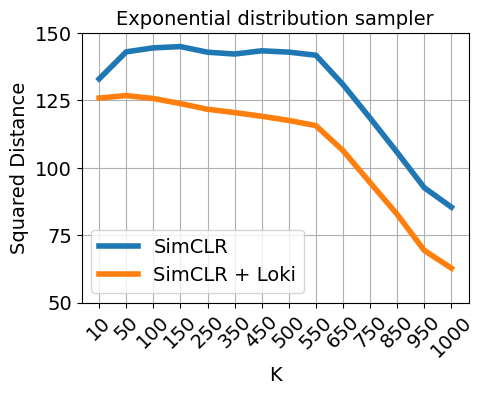

In [31]:
plt.figure(figsize=(5, 3.5))
plt.plot(exponential_baseline_collection[:, 0], label="SimCLR", linewidth=4)
plt.plot(exponential_proposed_method_collection[:, 0], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Squared Distance", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([50, 75, 100, 125, 150], [50, 75, 100, 125, 150], fontsize=14)
plt.xticks([i for i in range(len(exponential_baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Exponential distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

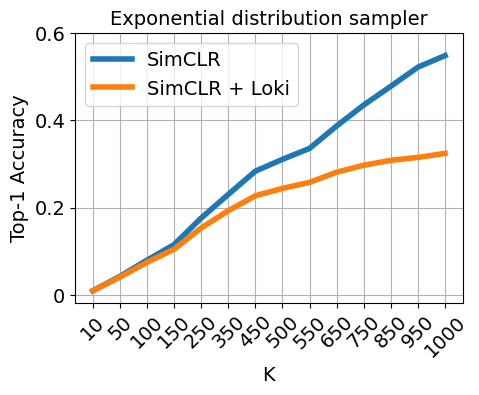

In [32]:
plt.figure(figsize=(5, 3.5))
plt.plot(exponential_baseline_collection[:, 1], label="SimCLR", linewidth=4)
plt.plot(exponential_proposed_method_collection[:, 1], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Top-1 Accuracy", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6], [0, 0.2, 0.4, 0.6], fontsize=14)
plt.xticks([i for i in range(len(exponential_baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Exponential distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

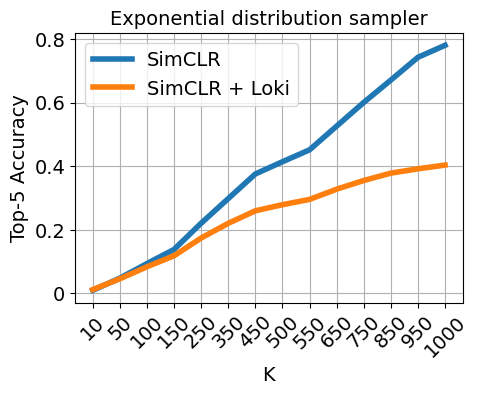

In [33]:
plt.figure(figsize=(5, 3.5))
plt.plot(exponential_baseline_collection[:, 2], label="SimCLR", linewidth=4)
plt.plot(exponential_proposed_method_collection[:, 2], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Top-5 Accuracy", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], [0, 0.2, 0.4, 0.6, 0.8], fontsize=14)
plt.xticks([i for i in range(len(exponential_baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Exponential distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

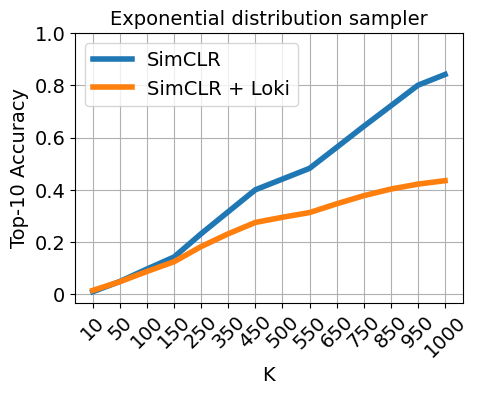

In [34]:
plt.figure(figsize=(5, 3.5))
plt.plot(exponential_baseline_collection[:, 3], label="SimCLR", linewidth=4)
plt.plot(exponential_proposed_method_collection[:, 3], label="SimCLR + Loki", linewidth=4)
plt.ylabel("Top-10 Accuracy", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xticks([i for i in range(len(exponential_baseline_collection))], classes_, fontsize=14, rotation=45)
plt.title("Exponential distribution sampler", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

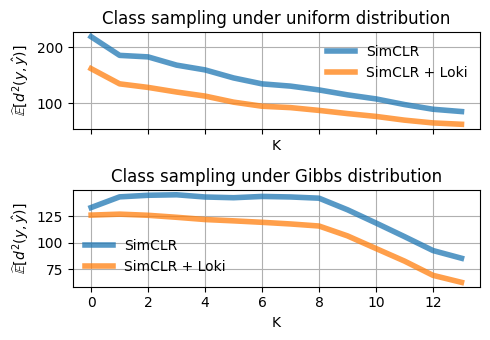

In [57]:

figure, axis = plt.subplots(2, 1, sharex=True, figsize=(5, 3.5))

axis[0].plot(uniform_baseline_collection[:, 0], label="SimCLR", linewidth=4, alpha=0.75)
axis[0].plot(uniform_proposed_method_collection[:, 0], label="SimCLR + Loki", linewidth=4, alpha=0.75)
axis[0].set_ylabel(r"$\widehat{\mathbb{E}}[d^2(y, \hat{y})]$")
axis[0].set_xlabel("K")
#axis[0].set_yticks([60, 80, 100, 120, 140, 160, 180, 200, 220], [60, 80, 100, 120, 140, 160, 180, 200, 220], fontsize=14)
#plt.xticks([i for i in range(len(baseline_collection))], classes_, fontsize=14, rotation=45)
#axis[0].set_xscale("log")
axis[0].set_title("Class sampling under uniform distribution")
axis[0].legend(frameon=False)
axis[0].grid()


axis[1].plot(exponential_baseline_collection[:, 0], label="SimCLR", linewidth=4, alpha=0.75)
axis[1].plot(exponential_proposed_method_collection[:, 0], label="SimCLR + Loki", linewidth=4, alpha=0.75)
axis[1].set_ylabel(r"$\widehat{\mathbb{E}}[d^2(y, \hat{y})]$")
axis[1].set_xlabel("K")
#axis[1].yticks([50, 75, 100, 125, 150], [50, 75, 100, 125, 150])
#axis[1].xticks([i for i in range(len(exponential_baseline_collection))], classes_, rotation=45)
#axis[1].set_xscale("log")
axis[1].set_title("Class sampling under Gibbs distribution")
axis[1].legend(frameon=False)
axis[1].grid()


plt.tight_layout()

plt.savefig(f"results/imagenet_result.pdf")

plt.show()